# Stock Bond Correlation

This notebook will examine the stock bond correlation relationship looking at previous work and comparing the results with Gerber correlation vs. Pearson Correlation

# Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Graham Capital: Equity-Bond Correlation: A Historical Perspective

[Original Paper](https://www.grahamcapital.com/assets/ResearchPapers/Equity-Bond%20Correlation_Graham%20Research_2017.pdf)

## Access Gerber Object

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))
from Gerber import Gerber

## Collect Data

In [3]:
link = "http://www.econ.yale.edu/~shiller/data/ie_data.xls"
df_raw = (pd.read_excel(
    io = link,
    sheet_name = "Data",
    skiprows = 6))

col_renamer = {
    "Unnamed: 0": "spx_date",
    "Comp.": "spx_price",
    "Interest": "long_term_rate"}

df_clean = (df_raw.rename(
    columns = col_renamer)
    [list(col_renamer.values())].
    iloc[1:].
    dropna())

df_month = (df_clean.assign(
    month = lambda x: x.spx_date.astype(str).str.split(".").str[1]).
    month.
    drop_duplicates().
    to_frame().
    reset_index().
    rename(columns = {"index": "new_month"}))

In [4]:
df_prep = (df_clean.assign(
    month = lambda x: x.spx_date.astype(str).str.split(".").str[1]).
    merge(right = df_month, how = "inner", on = ["month"]).
    drop(columns = ["month"]).
    assign(
        year_date = lambda x: x.spx_date.astype(str).str.split(".").str[0] + "-" + x.new_month.astype(str),
        date = lambda x: pd.to_datetime(x.year_date, format = "%Y-%m")).
    drop(columns = ["new_month", "spx_date", "year_date"]).
    set_index("date").
    sort_index())

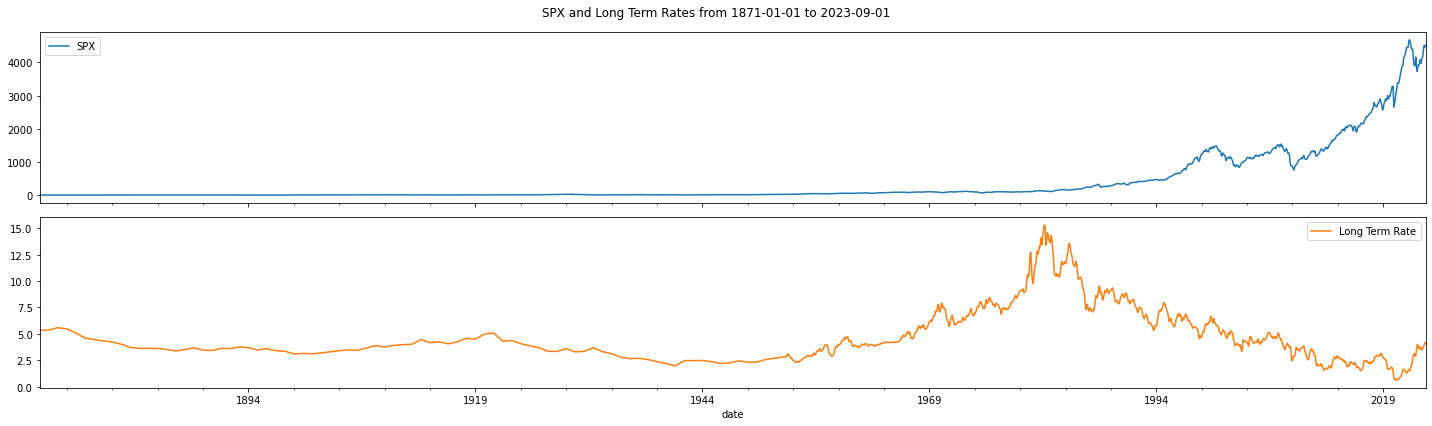

In [5]:
(df_prep.rename(
    columns = {
        "spx_price": "SPX",
        "long_term_rate": "Long Term Rate"}).
    plot(
        subplots = True,
        figsize = (20,6),
        layout = (2,1),
        title = "SPX and Long Term Rates from {} to {}".format(
            df_prep.index.min().date(),
            df_prep.index.max().date())))

plt.tight_layout()
plt.show()

## Synthetic Bond Returns

"back-out" bond returns by multiplying change in yield by constant duration of 9 (carry) and price changes of the bond from getting prorated bond return

In [6]:
df_bond_price = (df_prep.assign(
    carry = lambda x: x.long_term_rate.shift(1) * 9,
    price_change = lambda x: (x.long_term_rate.shift(1) - x.long_term_rate) * 1_000,
    bond_rtn = lambda x: x.price_change + x.carry))

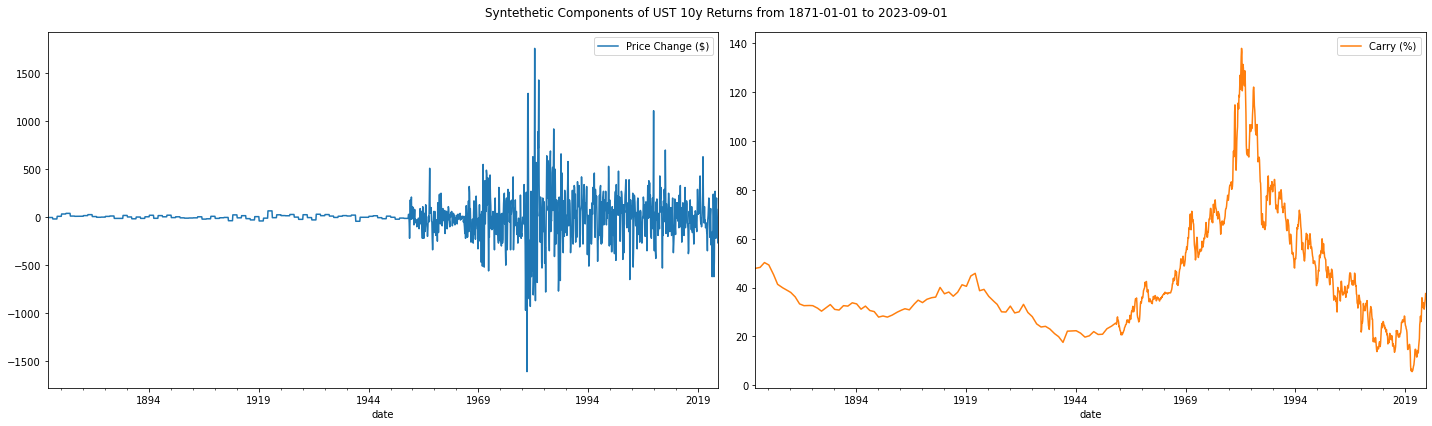

In [7]:
(df_bond_price[
    ["price_change", "carry"]].
    rename(columns = {
        "price_change": "Price Change ($)",
        "carry": "Carry (%)"}).
    plot(
        subplots = True,
        layout = (1,2),
        figsize = (20,6),
        title = "Syntethetic Components of UST 10y Returns from {} to {}".format(
            df_bond_price.index.min().date(),
            df_bond_price.index.max().date())))

plt.tight_layout()
plt.show()

## Correlation vs. Gerber

In [8]:
df_corr = (df_bond_price[
    ["spx_price", "bond_rtn"]].
    assign(
        spx_price = lambda x: x.spx_price.pct_change(),
        rolling_1y = lambda x: x.spx_price.rolling(window = 12).corr(x.bond_rtn),
        rolling_5y = lambda x: x.spx_price.rolling(window = 12 * 5).corr(x.bond_rtn)))

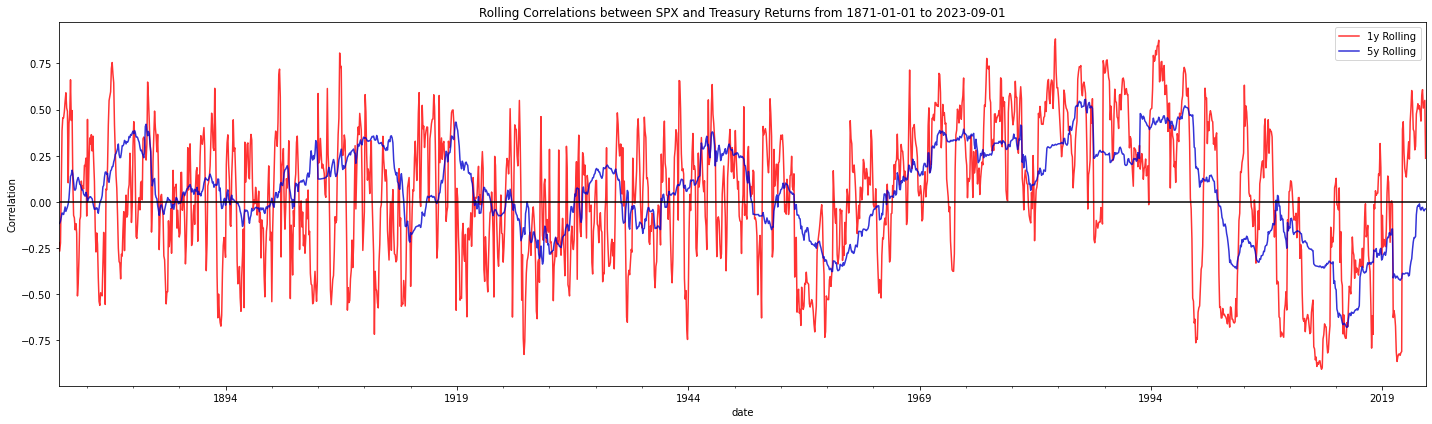

In [9]:
fig, axes = plt.subplots(figsize = (20,6))

(df_corr[
    ["rolling_1y", "rolling_5y"]].
    dropna().
    rename(columns = {
        "rolling_1y": "1y Rolling",
        "rolling_5y": "5y Rolling"}).
    plot(
        ax = axes,
        color = ["red", "mediumblue"],
        alpha = 0.8,
        ylabel = "Correlation",
        title = "Rolling Correlations between SPX and Treasury Returns from {} to {}".format(
            df_corr.index.min().date(),
            df_corr.index.max().date())))

axes.axhline(y = 0, color = "black")

plt.tight_layout()
plt.show()

In [10]:
df_rtn = (df_bond_price[
    ["spx_price", "bond_rtn"]].
    assign(spx_price = lambda x: x.spx_price.pct_change()).
    dropna())

rtns = df_rtn

In [11]:
gerber1 = Gerber().rolling_gerber_corr(rtns = df_rtn, window = 12)
gerber5 = Gerber().rolling_gerber_corr(rtns = df_rtn, window = 12 * 5)

In [19]:
df_gerber = (gerber1.rename(
    columns = {"gerber_stat": "Rolling 1y"}).
    merge(
        right = (gerber5.rename(
            columns = {"gerber_stat": "Rolling 5y"})),
        how = "inner",
        on = ["date"]).
    dropna())

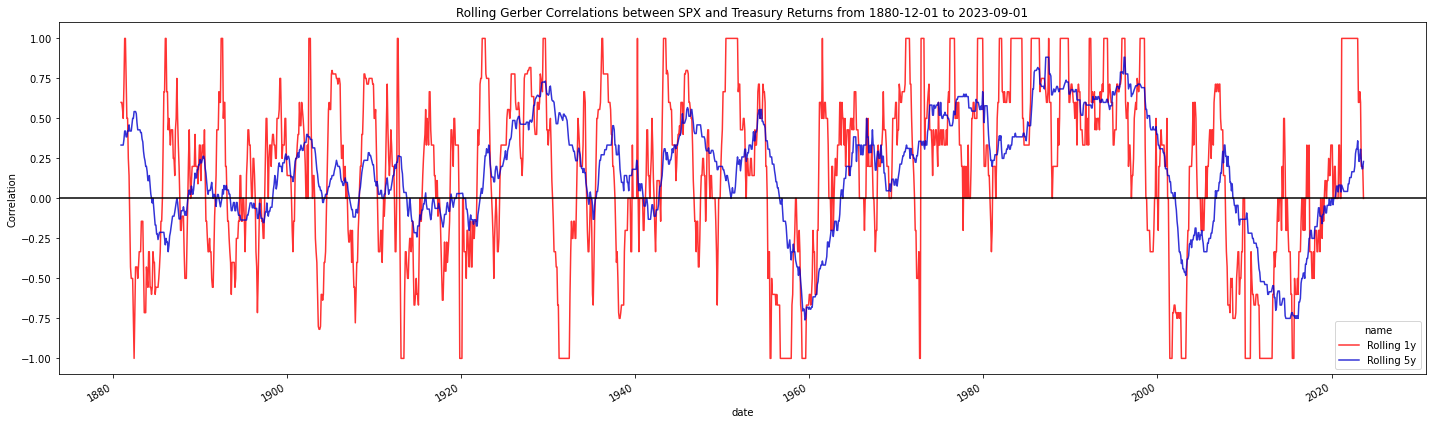

In [21]:
fig, axes = plt.subplots(figsize = (20,6))

(df_gerber.plot(
    ax = axes,
    color = ["red", "mediumblue"],
    alpha = 0.8,
    ylabel = "Correlation",
    title = "Rolling Gerber Correlations between SPX and Treasury Returns from {} to {}".format(
        df_gerber.index.min().date(),
        df_gerber.index.max().date())))

axes.axhline(y = 0, color = "black")

plt.tight_layout()
plt.show()

## Comparing 5y Gerber and Pearson Correlation

In [26]:
df_compare = (df_gerber[
    ["Rolling 5y"]].
    rename(columns = {"Rolling 5y": "Gerber"}).
    merge(
        right = df_corr[["rolling_5y"]], how = "inner", on = ["date"]).
    rename(columns = {
        "rolling_5y": "Pearson"}))

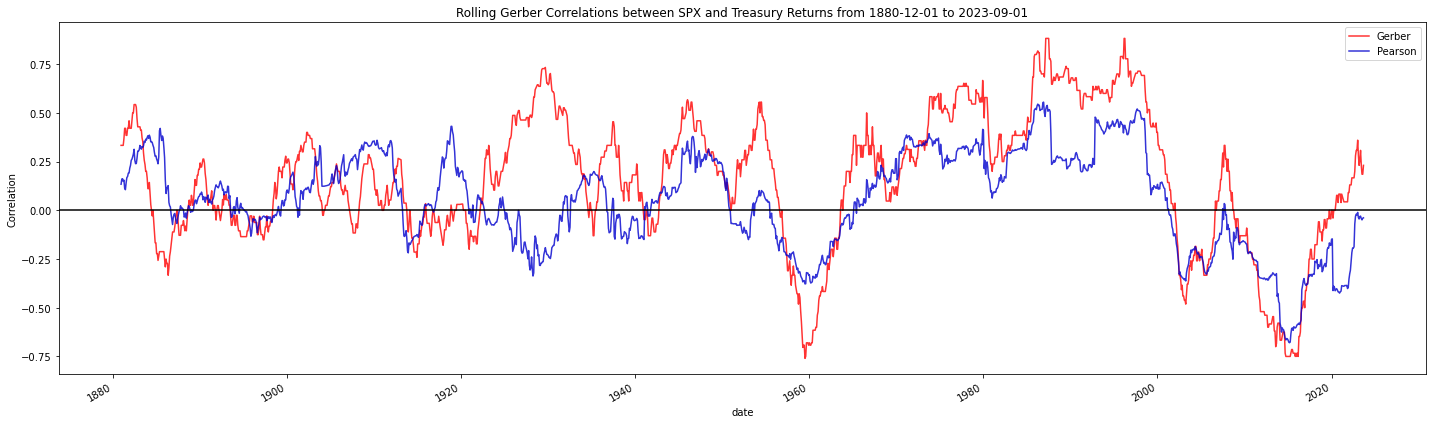

In [29]:
fig, axes = plt.subplots(figsize = (20,6))

(df_compare.plot(
    ax = axes,
    color = ["red", "mediumblue"],
    alpha = 0.8,
    ylabel = "Correlation",
    title = "Rolling Gerber Correlations between SPX and Treasury Returns from {} to {}".format(
        df_compare.index.min().date(),
        df_compare.index.max().date())))

axes.axhline(y = 0, color = "black")

plt.tight_layout()
plt.show()